# Import Dependency

In [37]:
import pandas as pd
import gdown
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report as sk_classification_report, confusion_matrix
from gensim.models import KeyedVectors
from torchcrf import CRF
import matplotlib.pyplot as plt
import seaborn as sns
from seqeval.scheme import IOB2
# ==============================
# SeqEval (for NER entity-level)
# ==============================
import seqeval.metrics as seqm

# ==============================
# Scikit-learn (for token-level)
# ==============================
import sklearn.metrics as skm
import json

#Data Loading & Analysis

In [2]:


# Accident dataset
!gdown --id 1pvOB9LDpkzEY54sMrutM7uYKvXra22Yd -O ./accident-preprocessed.csv

# Earthquake dataset
!gdown --id 1oBiMtK-r-PLkRbN-SDYJq4qrhzP6V_-F -O ./earthquake-preprocessed.csv

# Fire dataset
!gdown --id 19n3WUdJHjRfTNWjuOfpCCCDvl9KO9nJY -O ./fire-preprocessed.csv

# Flood dataset
!gdown --id 1WVo85Y26GdnTwKKfvEv0E49tERFjvgPA -O ./flood-preprocessed.csv

# Labeled dataset
!gdown --id 1EAfaJxkFdKx400hDhoysS_8TB-PiYZhZ -O ./all-labeled-data.csv
# File paths (adjust if your filenames are slightly different)
accident_file = "accident-preprocessed.csv"
earthquake_file = "earthquake-preprocessed.csv"
fire_file = "fire-preprocessed.csv"
flood_file = "flood-preprocessed.csv"

# Load each dataset
df_accident = pd.read_csv(accident_file)
df_earthquake = pd.read_csv(earthquake_file)
df_fire = pd.read_csv(fire_file)
df_flood = pd.read_csv(flood_file)

# Add a new column to mark the disaster type
df_accident["disaster_type"] = "accident"
df_earthquake["disaster_type"] = "earthquake"
df_fire["disaster_type"] = "fire"
df_flood["disaster_type"] = "flood"

# Combine into one DataFrame
df_all = pd.concat([df_accident, df_earthquake, df_fire, df_flood], ignore_index=True)

# Show info
print("Combined dataset shape:", df_all.shape)
print(df_all.head(10))

C:\Users\ariq\anaconda3\envs\nlptugas2\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pvOB9LDpkzEY54sMrutM7uYKvXra22Yd
To: G:\@CODE\NLP\accident-preprocessed.csv

  0%|          | 0.00/1.57M [00:00<?, ?B/s]
 33%|###3      | 524k/1.57M [00:00<00:00, 4.30MB/s]
100%|##########| 1.57M/1.57M [00:00<00:00, 9.70MB/s]
C:\Users\ariq\anaconda3\envs\nlptugas2\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1oBiMtK-r-PLkRbN-SDYJq4qrhzP6V_-F
To: G:\@CODE\NLP\earthquake-preprocessed.csv

  0%|          | 0.00/1.62M [00:00<?, ?B/s]
 32%|###2      | 524k/1.62M [00:00<00:00, 4.90MB/s]
100%|##########| 

Combined dataset shape: (56135, 4)
                  created_at              id_str  \
0  2018-01-01 22:28:01+00:00  947957609776103424   
1  2018-01-01 22:45:19+00:00  947961967406301184   
2  2018-01-01 23:05:40+00:00  947967088123035648   
3  2018-01-01 23:10:55+00:00  947968408980615168   
4  2018-01-01 23:12:42+00:00  947968858320642048   
5  2018-01-01 23:15:52+00:00  947969653015539712   
6  2018-01-01 23:23:15+00:00  947971511582904321   
7  2018-01-01 23:26:06+00:00  947972228922204160   
8  2018-01-01 23:42:49+00:00  947976434387181568   
9  2018-01-01 23:53:46+00:00  947979192188125184   

                                           full_text disaster_type  
0  0527: imbas kecelakaan di jembatan ciherang se...      accident  
1  05:42 kecelakaan daihatsu xenia b 1877 vmf &am...      accident  
2  imbas kecelakaan di jembatan ciherang sebelum ...      accident  
3  kecelakaan di cipularang arah bandung kamu 102...      accident  
4  terjadi kecelakaan di kamu 34 tol cikampek a

C:\Users\ariq\anaconda3\envs\nlptugas2\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1EAfaJxkFdKx400hDhoysS_8TB-PiYZhZ
To: G:\@CODE\NLP\all-labeled-data.csv

  0%|          | 0.00/3.83M [00:00<?, ?B/s]
 14%|#3        | 524k/3.83M [00:00<00:00, 5.08MB/s]
100%|##########| 3.83M/3.83M [00:00<00:00, 22.2MB/s]


## helper functions

In [3]:
def tokens_to_indices(tokens_list, word2idx, max_len):
    indices_all = []
    for tokens in tokens_list:
        indices = [word2idx.get(t, word2idx["<unk>"]) for t in tokens]
        if len(indices) < max_len:
            indices += [word2idx["<pad>"]] * (max_len - len(indices))
        else:
            indices = indices[:max_len]
        indices_all.append(indices)
    return torch.tensor(indices_all, dtype=torch.long)
    
'''def tokens_to_indices(tokens_list, word2idx, max_len):
    indices_all = []
    for tokens in tokens_list:
        indices = [word2idx.get(t, word2idx["<unk>"]) for t in tokens]
        if len(indices) < max_len:
            indices += [word2idx["<pad>"]] * (max_len - len(indices))
        else:
            indices = indices[:max_len]
        indices_all.append(indices)
    return torch.tensor(indices_all, dtype=torch.long) '''

def encode_labels(labels_list, le_ft, max_len):
    y_all = []
    for labels in labels_list:
        ids = le_ft.transform(labels)
        if len(ids) < max_len:
            ids = list(ids) + [pad_label_id] * (max_len - len(ids))   # <--- FIXED
        else:
            ids = ids[:max_len]
        y_all.append(ids)
    return torch.tensor(y_all, dtype=torch.long)
    
'''def encode_labels(labels_list, le_ftp, max_len):
    y_all = []
    for labels in labels_list:
        ids = le_ftp.transform(labels)
        if len(ids) < max_len:
            ids = list(ids) + [pad_label_id] * (max_len - len(ids))
        else:
            ids = ids[:max_len]
        y_all.append(ids)
    return torch.tensor(y_all, dtype=torch.long)'''
    
def plot_confusion_matrix(flat_true, flat_pred, labels, model_name):
    cm = confusion_matrix(flat_true, flat_pred, labels=labels)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
def show_examples_ftscratch(sentences, y_true, y_pred, model_name="FastText-scratch BiLSTM-CRF", n=5):
    print(f"\n[Sample Predictions — {model_name}]")
    shown = 0
    for sent, gold_seq, pred_seq in zip(sentences, y_true, y_pred):
        if gold_seq != pred_seq:  # only show mistakes
            print("Sentence: ", " ".join(sent[:len(gold_seq)]))
            print("Gold:     ", gold_seq)
            print("Pred:     ", pred_seq)
            print("-" * 50)
            shown += 1
        if shown >= n:
            break
def show_examples_ftpretrain(sentences, y_true, y_pred, model_name="FastText-BiLSTM-CRF", n=5):
    print(f"\n[Sample Predictions — {model_name}]")
    shown = 0
    for sent, gold_seq, pred_seq in zip(sentences, y_true, y_pred):
        if gold_seq != pred_seq:  # only show mistakes
            print("Sentence: ", " ".join(sent[:len(gold_seq)]))
            print("Gold:     ", gold_seq)
            print("Pred:     ", pred_seq)
            print("-" * 50)
            shown += 1
        if shown >= n:
            break
            
def show_examples_indobert(X_test_ids, y_true, y_pred, tokenizer, n=5, model_name="IndoBERTweet"):
    print(f"\nExamples for {model_name}:\n" + "-"*50)
    shown = 0

    for i in range(len(y_true)):
        gold = y_true[i]
        pred = y_pred[i]
        if len(gold) == 0 or len(pred) == 0:
            continue

        # flatten + filter invalid ids
        token_ids = np.array(X_test_ids[i]).reshape(-1).tolist()
        token_ids = [tid for tid in token_ids if tid >= 0]

        tokens = tokenizer.convert_ids_to_tokens(token_ids)

        # align tokens with gold labels
        tokens = tokens[:len(gold)]

        # merge WordPiece tokens
        clean_tokens = []
        for tok in tokens:
            if tok.startswith("##") and clean_tokens:
                clean_tokens[-1] = clean_tokens[-1] + tok[2:]
            else:
                clean_tokens.append(tok)

        if shown < n:
            print("Sentence:", " ".join(clean_tokens))
            print("Gold:    ", gold)
            print("Pred:    ", pred)
            print()
            shown += 1

def evaluate_model_ftscratch(model, data_loader, le_ft, device):
    """
    Evaluate FastText-scratch BiLSTM-CRF model.
    Returns seqeval-compatible y_true/y_pred (list of list) and flattened lists.
    Also prints entity-level and token-level reports.
    """
    model.eval()
    all_true, all_pred = [], []
    flat_true, flat_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            mask = (X_batch != word2idx["<pad>"]).to(device)

            preds = model(X_batch, mask=mask)  # CRF.decode → list[list[int]]

            for i in range(len(X_batch)):
                true_ids = y_batch[i][mask[i]].cpu().numpy()
                pred_ids = preds[i]

                valid_true = [le_ft.inverse_transform([t])[0] for t in true_ids if t != -100]
                valid_pred = [le_ft.inverse_transform([p])[0] for p in pred_ids]

                # align lengths
                min_len = min(len(valid_true), len(valid_pred))
                valid_true, valid_pred = valid_true[:min_len], valid_pred[:min_len]

                all_true.append(valid_true)
                all_pred.append(valid_pred)

                flat_true.extend(valid_true)
                flat_pred.extend(valid_pred)

    # ------------------------
    # Reports
    # ------------------------
    print("\n[Entity-level report — seqeval]")
    print(seqm.classification_report(all_true, all_pred, digits=4, mode="strict", scheme=IOB2))

    print("\n[Token-level report — sklearn]")
    print("Token Accuracy:", skm.accuracy_score(flat_true, flat_pred))
    print("Macro F1:", skm.f1_score(flat_true, flat_pred, average="macro"))
    print("Macro Precision:", skm.precision_score(flat_true, flat_pred, average="macro"))
    print("Macro Recall:", skm.recall_score(flat_true, flat_pred, average="macro"))
    print(skm.classification_report(flat_true, flat_pred, digits=4))

    return all_true, all_pred, flat_true, flat_pred

def evaluate_model_ftpretrain(model, data_loader, le_ftp, device):
    """
    Evaluate FastText-pretrained BiLSTM-CRF model.
    Returns seqeval-compatible y_true/y_pred (list of list) and flattened lists.
    Also prints entity-level and token-level reports.
    """
    model.eval()
    all_true, all_pred = [], []
    flat_true, flat_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            mask = (X_batch != word2idx["<pad>"])  # valid tokens

            preds = model(X_batch.to(device), mask=mask.to(device))

            for i in range(len(X_batch)):
                true_ids = y_batch[i][mask[i]].cpu().numpy()
                pred_ids = preds[i]

                valid_true = [le_ftp.inverse_transform([t])[0] for t in true_ids]
                valid_pred = [le_ftp.inverse_transform([p])[0] for p in pred_ids]

                # align lengths
                min_len = min(len(valid_true), len(valid_pred))
                valid_true, valid_pred = valid_true[:min_len], valid_pred[:min_len]

                all_true.append(valid_true)
                all_pred.append(valid_pred)

                flat_true.extend(valid_true)
                flat_pred.extend(valid_pred)

    # ------------------------
    # Reports
    # ------------------------
    print("\n[Entity-level report — seqeval]")
    print(seqm.classification_report(all_true, all_pred, digits=4, mode="strict", scheme=IOB2))

    print("\n[Token-level report — sklearn]")
    print(skm.classification_report(flat_true, flat_pred, digits=4))

    return all_true, all_pred, flat_true, flat_pred

def decode_predictions(preds, labels, mask, le):
    """
    preds: list/array of predicted label ids per sequence
    labels: tensor of gold label ids (with padding or -100)
    mask: tensor (bool) indicating valid tokens
    le: LabelEncoder
    """
    y_true, y_pred = [], []
    flat_true, flat_pred = [], []

    for i in range(len(preds)):
        pred_seq = preds[i]
        true_seq = labels[i].cpu().numpy()
        mask_seq = mask[i].cpu().numpy()

        # Filter using mask
        filtered_true_ids = [t for t, m in zip(true_seq, mask_seq) if m and t != -100]
        filtered_pred_ids = [p for p, m in zip(pred_seq, mask_seq) if m]

        # Convert IDs to labels
        filtered_true = le.inverse_transform(filtered_true_ids)
        filtered_pred = le.inverse_transform(filtered_pred_ids)

        y_true.append(filtered_true.tolist())
        y_pred.append(filtered_pred.tolist())

        flat_true.extend(filtered_true.tolist())
        flat_pred.extend(filtered_pred.tolist())

    return y_true, y_pred, flat_true, flat_pred


def evaluate_model_indoberttweet(model, data_loader, le, device):
    """
    Evaluate IndoBERTweet BiLSTM-CRF model.
    Returns seqeval-compatible y_true/y_pred (list of list) and flattened lists.
    """
    model.eval()
    all_true, all_pred = [], []
    flat_true, flat_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # mask is based on labels != -100
            mask = (y_batch != -100)

            preds = model(X_batch, mask=mask)

            y_true, y_pred, f_true, f_pred = decode_predictions(preds, y_batch, mask, le)
            all_true.extend(y_true)
            all_pred.extend(y_pred)
            flat_true.extend(f_true)
            flat_pred.extend(f_pred)

    return all_true, all_pred, flat_true, flat_pred

# Model Implementation (Stage 2)

## fasttext from scratch

* Bi-directional LSTM with CRF (Bi-LSTM CRF):
* Implement a Bi-LSTM CRF model using a deep learning library (e.g., TensorFlow,
PyTorch).
* Use word embeddings (pre-trained or trained from scratch) to represent words.

In [4]:
# ============================================
# 1. Install & Imports
# ============================================


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from gensim.models import FastText
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from torchcrf import CRF
from tqdm import tqdm
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


# Load labeled dataset (for supervised NER)
df_labeled = pd.read_csv("all-labeled-data.csv")
print("Labeled dataset shape:", df_labeled.shape)
print(df_labeled.head())



Labeled dataset shape: (99206, 5)
     text_id             id    token entity argument
0  BAN-00001  BAN-00001.001       13      O        O
1  BAN-00001  BAN-00001.002    janji      O        O
2  BAN-00001  BAN-00001.003     akan      O        O
3  BAN-00001  BAN-00001.004  mencari      O        O
4  BAN-00001  BAN-00001.005   solusi      O        O


In [5]:
# Use the text column containing full preprocessed tweets
sentences = [str(t).split() for t in df_all['full_text']]

ft_model = FastText(
    vector_size=100, window=5, min_count=1, sg=1, epochs=50
)
ft_model.build_vocab(sentences)
ft_model.train(sentences, total_examples=len(sentences), epochs=50)


(55579538, 64146350)

In [6]:
# word2idx dictionary
word2idx = {w: i+2 for i, w in enumerate(ft_model.wv.index_to_key)}
word2idx["<pad>"] = 0
word2idx["<unk>"] = 1

# embedding matrix
embedding_matrix = np.zeros((len(word2idx), ft_model.vector_size))
for w, i in word2idx.items():
    if w in ft_model.wv:
        embedding_matrix[i] = ft_model.wv[w]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(ft_model.vector_size,))

In [7]:
# ======================================
# 2. Prepare NER sequences & labels
# ======================================

# Group tokens + labels by text_id
sentences_tokens, sentences_labels = [], []
current_tokens, current_labels = [], []
prev_id = None

for _, row in df_labeled.iterrows():
    tid = row["text_id"]
    token = str(row["token"])
    label = str(row["entity"])   # Already BIO
    if tid != prev_id and prev_id is not None:
        sentences_tokens.append(current_tokens)
        sentences_labels.append(current_labels)
        current_tokens, current_labels = [], []
    current_tokens.append(token)
    current_labels.append(label)
    prev_id = tid

# add last
if current_tokens:
    sentences_tokens.append(current_tokens)
    sentences_labels.append(current_labels)

print("NER sentences:", len(sentences_tokens))

# Build vocab from FastText-trained word2idx
max_len = 100



# Label encoder on BIO tags (+ PAD)
all_labels = sorted(set(l for labs in sentences_labels for l in labs))
all_labels.append("PAD")   # <--- NEW
le_ft = LabelEncoder()
le_ft.fit(all_labels)
pad_label_id = le_ft.transform(["PAD"])[0]



# Encode
X = tokens_to_indices(sentences_tokens, word2idx, max_len)
y = encode_labels(sentences_labels, le_ft, max_len)

NER sentences: 4150


C:\Users\ariq\AppData\Local\Temp\ipykernel_16088\249283310.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  return torch.tensor(y_all, dtype=torch.long)


In [8]:
# ======================================
# 2b. Dataset and DataLoader
# ======================================
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Train/valid/test split
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_loader_ftscratch = DataLoader(NERDataset(X_train, y_train), batch_size=32, shuffle=True)
valid_loader_ftscratch = DataLoader(NERDataset(X_valid, y_valid), batch_size=32)
test_loader_ftscratch  = DataLoader(NERDataset(X_test, y_test), batch_size=32)


In [9]:
# ======================================
# 3. BiLSTM + CRF model
# ======================================
class BiLSTM_CRF_FT_scratch(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, embedding_matrix=None):
        super(BiLSTM_CRF_FT_scratch, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2idx['<pad>'])
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False   # freeze at start (can unfreeze later)

        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=1,
            bidirectional=True, batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, x, tags=None, mask=None):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        emissions = self.fc(lstm_out)

        if tags is not None:   # Training
            return -self.crf(emissions, tags, mask=mask, reduction="mean")
        else:                  # Inference
            return self.crf.decode(emissions, mask=mask)

In [10]:
# ======================================
# 4. Training loop
# ======================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(le_ft.classes_)

ft_model_scratch = BiLSTM_CRF_FT_scratch(
    vocab_size=len(word2idx),
    embedding_dim=ft_model.vector_size,
    hidden_dim=128,
    num_labels=num_labels,
    embedding_matrix=embedding_matrix
).to(device)

optimizer = torch.optim.Adam(ft_model_scratch.parameters(), lr=0.001)
epochs = 30

for epoch in range(epochs):
    ft_model_scratch.train()
    total_loss = 0.0

    for X_batch, y_batch in train_loader_ftscratch:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        mask_ft_scratch = (X_batch != word2idx["<pad>"]).to(device)

        loss = ft_model_scratch(X_batch, y_batch, mask=mask_ft_scratch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_ftscratch)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}")

Epoch 1/30, Train Loss: 28.4061
Epoch 2/30, Train Loss: 15.2449
Epoch 3/30, Train Loss: 11.4505
Epoch 4/30, Train Loss: 9.9737
Epoch 5/30, Train Loss: 9.0017
Epoch 6/30, Train Loss: 8.3126
Epoch 7/30, Train Loss: 7.6881
Epoch 8/30, Train Loss: 7.1826
Epoch 9/30, Train Loss: 6.6975
Epoch 10/30, Train Loss: 6.2935
Epoch 11/30, Train Loss: 5.9406
Epoch 12/30, Train Loss: 5.5462
Epoch 13/30, Train Loss: 5.1768
Epoch 14/30, Train Loss: 4.8934
Epoch 15/30, Train Loss: 4.5128
Epoch 16/30, Train Loss: 4.1972
Epoch 17/30, Train Loss: 3.8530
Epoch 18/30, Train Loss: 3.5864
Epoch 19/30, Train Loss: 3.2791
Epoch 20/30, Train Loss: 2.9689
Epoch 21/30, Train Loss: 2.7660
Epoch 22/30, Train Loss: 2.5421
Epoch 23/30, Train Loss: 2.2327
Epoch 24/30, Train Loss: 2.0114
Epoch 25/30, Train Loss: 1.8058
Epoch 26/30, Train Loss: 1.6096
Epoch 27/30, Train Loss: 1.4252
Epoch 28/30, Train Loss: 1.2675
Epoch 29/30, Train Loss: 1.1081
Epoch 30/30, Train Loss: 0.9751


## fasttext from scratch result


[Entity-level report — seqeval]
              precision    recall  f1-score   support

         ARG     0.5584    0.5253    0.5413       455
         EVE     0.9393    0.9413    0.9403       460
         LOC     0.6896    0.6626    0.6758       409
         ORG     0.6848    0.4773    0.5625       132
        PLOC     0.6205    0.5305    0.5720       262

   micro avg     0.7165    0.6665    0.6906      1718
   macro avg     0.6985    0.6274    0.6584      1718
weighted avg     0.7108    0.6665    0.6865      1718


[Token-level report — sklearn]
Token Accuracy: 0.8753138075313808
Macro F1: 0.7198587999657531
Macro Precision: 0.7515882800197272
Macro Recall: 0.6939592688658126
              precision    recall  f1-score   support

       B-ARG     0.7079    0.6659    0.6863       455
       B-EVE     0.9610    0.9630    0.9620       460
       B-LOC     0.7455    0.7164    0.7307       409
       B-ORG     0.7065    0.4924    0.5804       132
      B-PLOC     0.6429    0.5496    0.592

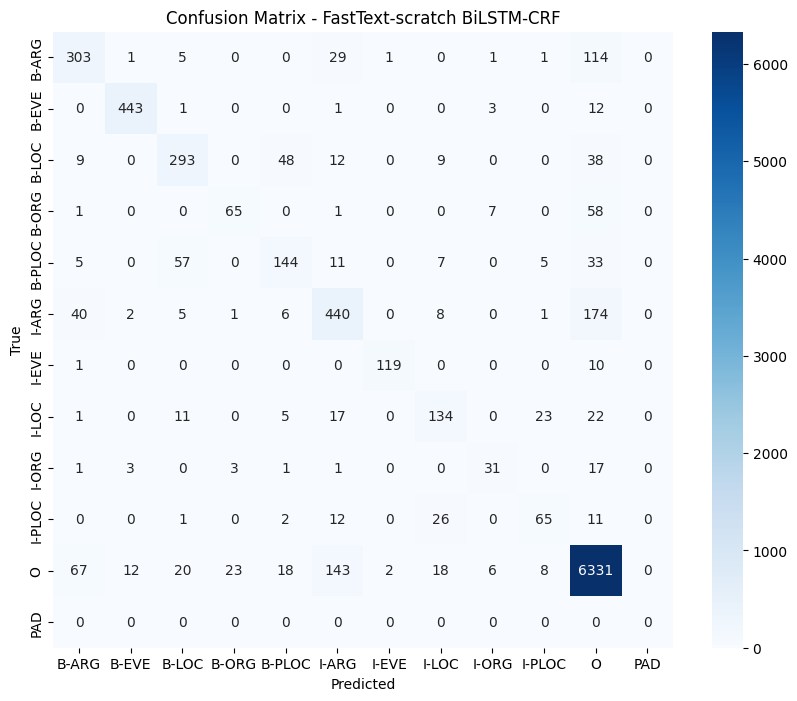


[Sample Predictions — FastText-scratch BiLSTM-CRF]
Sentence:  13 janji akan mencari solusi banjir jakarta dan kemacetan jakarta ketika jadi presiden bahkan statemen di 2014 akan menggunakan cara lain namun faktanya kini banyak barisan pendukung yang menyalahkan anies
Gold:      ['O', 'O', 'O', 'O', 'O', 'O', 'B-EVE', 'O', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-PLOC', 'O', 'B-PLOC', 'O', 'O', 'O', 'B-EVE', 'O', 'B-ARG', 'I-ARG', 'I-ARG', 'O', 'B-ARG', 'O', 'O']
Pred:      ['O', 'O', 'O', 'O', 'O', 'O', 'B-EVE', 'O', 'B-LOC', 'B-PLOC', 'O', 'O', 'O', 'O', 'O', 'B-PLOC', 'O', 'B-PLOC', 'O', 'O', 'O', 'B-EVE', 'O', 'B-ARG', 'I-ARG', 'O', 'O', 'O', 'O', 'O']
--------------------------------------------------
Sentence:  anak buah bantu set up pusat pemindahan banjir di balairaya
Gold:      ['O', 'O', 'B-EVE', 'O', 'B-LOC', 'B-ARG', 'I-ARG', 'O', 'O', 'O']
Pred:      ['O', 'O', 'B-EVE', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O']
--------------------------------------------------
Sentence:

In [11]:


# =====================================
# Evaluation for FastText (Scratch)
# =====================================

y_true_s, y_pred_s, flat_true_s, flat_pred_s = evaluate_model_ftscratch(
    ft_model_scratch, test_loader_ftscratch, le_ft, device
)
plot_confusion_matrix(flat_true_s, flat_pred_s, le_ft.classes_, "FastText-scratch BiLSTM-CRF")

show_examples_ftscratch(sentences_tokens, y_true_s, y_pred_s)

## fasttext pretrained

In [12]:
pretrained_ft = KeyedVectors.load_word2vec_format("cc.id.300.vec", binary=False)

# Build vocab from pretrained model
word2idx = {w: i+2 for i, w in enumerate(pretrained_ft.index_to_key)}
word2idx["<pad>"] = 0
word2idx["<unk>"] = 1

# Embedding matrix
embedding_matrix = np.zeros((len(word2idx), pretrained_ft.vector_size))

for w, i in tqdm(word2idx.items(), desc="Building embedding matrix", total=len(word2idx)):
    if w in pretrained_ft:
        embedding_matrix[i] = pretrained_ft[w]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(pretrained_ft.vector_size,))


Building embedding matrix: 100%|█████████████████████████████████████████| 2000002/2000002 [00:06<00:00, 323958.69it/s]


In [38]:
np.save("embedding_matrix_ftpretrain.npy", embedding_matrix)
with open("word2idx_ftpretrain.json", "w", encoding="utf-8") as f:
    json.dump(word2idx, f, ensure_ascii=False)

In [13]:
# ======================================
# 3. Prepare NER sequences & labels
# ======================================
sentences_tokens, sentences_labels = [], []
current_tokens, current_labels = [], []
prev_id = None

for _, row in df_labeled.iterrows():
    tid = row["text_id"]
    token = str(row["token"])
    label = str(row["entity"])   # BIO tags
    if tid != prev_id and prev_id is not None:
        sentences_tokens.append(current_tokens)
        sentences_labels.append(current_labels)
        current_tokens, current_labels = [], []
    current_tokens.append(token)
    current_labels.append(label)
    prev_id = tid

if current_tokens:
    sentences_tokens.append(current_tokens)
    sentences_labels.append(current_labels)

print("NER sentences:", len(sentences_tokens))

max_len = 100




NER sentences: 4150


In [14]:
# Label encoder
all_labels = sorted(set(l for labs in sentences_labels for l in labs))
all_labels.append("PAD")
le_ftp = LabelEncoder()
le_ftp.fit(all_labels)
pad_label_id = le_ftp.transform(["PAD"])[0]


X = tokens_to_indices(sentences_tokens, word2idx, max_len)
y = encode_labels(sentences_labels, le_ftp, max_len)

In [15]:
# ======================================
# 4. Dataset & DataLoader
# ======================================
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_loader_ftpretrain = DataLoader(NERDataset(X_train, y_train), batch_size=32, shuffle=True)
valid_loader_ftpretrain = DataLoader(NERDataset(X_valid, y_valid), batch_size=32)
test_loader_ftpretrain  = DataLoader(NERDataset(X_test, y_test), batch_size=32)

In [16]:
# ======================================
# 5. BiLSTM + CRF model
# ======================================
class BiLSTM_CRF_ft_pretrain(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, embedding_matrix=None):
        super(BiLSTM_CRF_ft_pretrain, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2idx['<pad>'])
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = False   # freeze at start

        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=1,
            bidirectional=True, batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, x, tags=None, mask=None):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        emissions = self.fc(lstm_out)

        if tags is not None:
            return -self.crf(emissions, tags, mask=mask, reduction="mean")
        else:
            return self.crf.decode(emissions, mask=mask)

In [17]:
# ======================================
# 6. Training Loop
# ======================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(le_ftp.classes_)

model_ftpretrain = BiLSTM_CRF_ft_pretrain(
    vocab_size=len(word2idx),
    embedding_dim=pretrained_ft.vector_size,
    hidden_dim=128,
    num_labels=num_labels,
    embedding_matrix=embedding_matrix
).to(device)

optimizer = torch.optim.Adam(model_ftpretrain.parameters(), lr=0.001)
epochs = 30

for epoch in range(epochs):
    model_ftpretrain.train()
    total_loss = 0.0

    for X_batch, y_batch in train_loader_ftpretrain:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        mask_ft_pretrain = (X_batch != word2idx["<pad>"]).to(device)

        loss = model_ftpretrain(X_batch, y_batch, mask=mask_ft_pretrain)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_ftpretrain)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}")

Epoch 1/30, Train Loss: 30.0981
Epoch 2/30, Train Loss: 18.1871
Epoch 3/30, Train Loss: 13.3523
Epoch 4/30, Train Loss: 11.4678
Epoch 5/30, Train Loss: 10.2526
Epoch 6/30, Train Loss: 9.3074
Epoch 7/30, Train Loss: 8.6085
Epoch 8/30, Train Loss: 8.1133
Epoch 9/30, Train Loss: 7.6386
Epoch 10/30, Train Loss: 7.2088
Epoch 11/30, Train Loss: 6.7987
Epoch 12/30, Train Loss: 6.4334
Epoch 13/30, Train Loss: 6.1127
Epoch 14/30, Train Loss: 5.8847
Epoch 15/30, Train Loss: 5.5142
Epoch 16/30, Train Loss: 5.2560
Epoch 17/30, Train Loss: 5.0286
Epoch 18/30, Train Loss: 4.7168
Epoch 19/30, Train Loss: 4.5167
Epoch 20/30, Train Loss: 4.3585
Epoch 21/30, Train Loss: 4.0488
Epoch 22/30, Train Loss: 3.8160
Epoch 23/30, Train Loss: 3.6105
Epoch 24/30, Train Loss: 3.3559
Epoch 25/30, Train Loss: 3.2017
Epoch 26/30, Train Loss: 2.9774
Epoch 27/30, Train Loss: 2.7977
Epoch 28/30, Train Loss: 2.6149
Epoch 29/30, Train Loss: 2.4091
Epoch 30/30, Train Loss: 2.2440


## fasttext pretrained result


[Entity-level report — seqeval]
              precision    recall  f1-score   support

         ARG     0.6104    0.4923    0.5450       455
         EVE     0.9379    0.9196    0.9286       460
         LOC     0.6817    0.6284    0.6539       409
         ORG     0.6867    0.4318    0.5302       132
        PLOC     0.5843    0.5687    0.5764       262

   micro avg     0.7241    0.6461    0.6829      1718
   macro avg     0.7002    0.6082    0.6468      1718
weighted avg     0.7169    0.6461    0.6773      1718


[Token-level report — sklearn]
              precision    recall  f1-score   support

       B-ARG     0.7520    0.6066    0.6715       455
       B-EVE     0.9645    0.9457    0.9550       460
       B-LOC     0.7321    0.6748    0.7023       409
       B-ORG     0.7952    0.5000    0.6140       132
      B-PLOC     0.6039    0.5878    0.5957       262
       I-ARG     0.7266    0.5968    0.6553       677
       I-EVE     0.9444    0.9154    0.9297       130
       I-LOC 

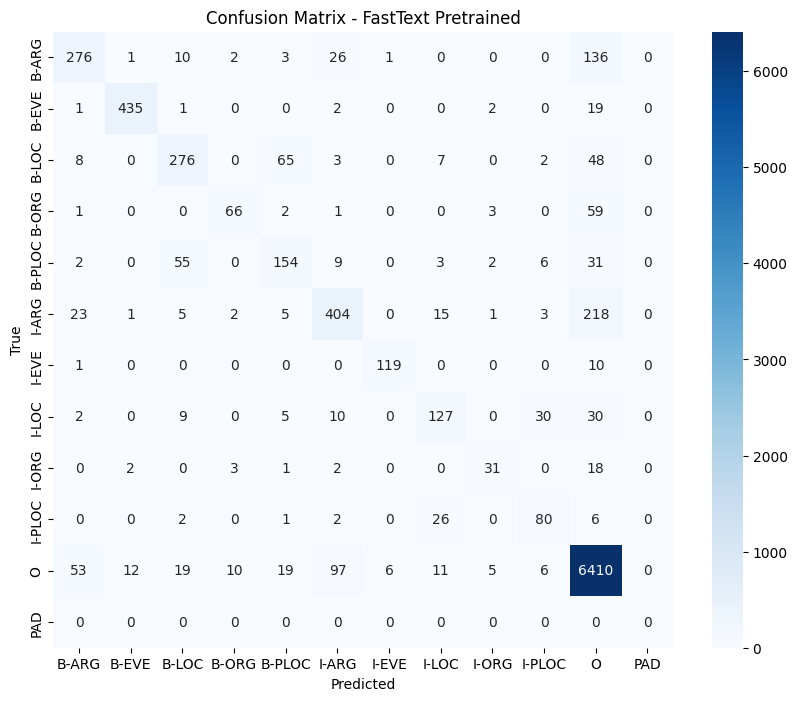


[Sample Predictions — FastText Pretrained]
Sentence:  13 janji akan mencari solusi banjir jakarta dan kemacetan jakarta ketika jadi presiden bahkan statemen di 2014 akan menggunakan cara lain namun faktanya kini banyak barisan pendukung yang menyalahkan anies
Gold:      ['O', 'O', 'O', 'O', 'O', 'O', 'B-EVE', 'O', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-PLOC', 'O', 'B-PLOC', 'O', 'O', 'O', 'B-EVE', 'O', 'B-ARG', 'I-ARG', 'I-ARG', 'O', 'B-ARG', 'O', 'O']
Pred:      ['O', 'O', 'O', 'O', 'O', 'O', 'B-EVE', 'O', 'B-LOC', 'B-PLOC', 'O', 'O', 'O', 'O', 'O', 'B-PLOC', 'O', 'B-PLOC', 'O', 'O', 'O', 'B-EVE', 'O', 'B-ARG', 'I-ARG', 'O', 'O', 'O', 'O', 'O']
--------------------------------------------------
Sentence:  intensitas dan curah hujan yang tinggi telah menyebabkan banjir di berbagai daerah di tanah air kala banjir melanda tetap tenang dan tingkatkan kewaspadaan berikut beberapa poin yang dapat dilakukan guna mengurangi risiko banjir
Gold:      ['O', 'O', 'O', 'O', 'O', 'O', 'O', 

In [18]:
# ======================================
# 7. Evaluation
# ======================================

y_true_p, y_pred_p, flat_true_p, flat_pred_p = evaluate_model_ftpretrain(
    model_ftpretrain, test_loader_ftpretrain, le_ftp, device
)
plot_confusion_matrix(flat_true_p, flat_pred_p, le_ftp.classes_, "FastText Pretrained")
show_examples_ftpretrain(sentences_tokens, y_true_p, y_pred_p, model_name="FastText Pretrained")

## indobertweet

In [19]:
#!pip install --upgrade transformers

In [20]:
# 1. Load IndoBERTweet
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd

model_name = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)
bert.eval()  # freeze weights


C:\Users\ariq\anaconda3\envs\nlptugas2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31923, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [21]:
# 2. Load dataset
df_labeled = pd.read_csv("all-labeled-data.csv")

texts, labels = [], []
for tid, group in df_labeled.groupby("text_id"):
    tokens = group["token"].astype(str).tolist()
    labs = group["entity"].astype(str).tolist()
    texts.append(tokens)
    labels.append(labs)

print("Sample tokens:", texts[0][:10])
print("Sample labels:", labels[0][:10])


Sample tokens: ['13', 'janji', 'akan', 'mencari', 'solusi', 'banjir', 'jakarta', 'dan', 'kemacetan', 'jakarta']
Sample labels: ['O', 'O', 'O', 'O', 'O', 'B-EVE', 'B-LOC', 'O', 'O', 'B-LOC']


In [22]:
# 3. Tokenize with alignment
encodings = tokenizer(
    texts,
    is_split_into_words=True,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

# Align labels (BIO → subwords)
label_list = sorted(set(l for seq in labels for l in seq))
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}
le_indobert = LabelEncoder()
le_indobert.classes_ = np.array(sorted(label2id.keys()))

aligned_labels = []
for i, label_seq in enumerate(labels):
    word_ids = encodings.word_ids(batch_index=i)
    prev_word_id = None
    label_ids = []
    for word_id in word_ids:
        if word_id is None:
            label_ids.append(-100)  # CLS/SEP
        elif word_id != prev_word_id:
            label_ids.append(label2id[label_seq[word_id]])  # first subword gets label
        else:
            label_ids.append(-100)  # ignore subword continuation
        prev_word_id = word_id
    aligned_labels.append(label_ids)

print("Aligned labels example:", aligned_labels[0][:20])


Aligned labels example: [-100, 10, 10, 10, 10, 10, 1, 2, 10, 10, 2, 10, 10, 3, 10, 10, 10, 0, 10, 10]


In [23]:
'''all_encodings = tokenizer(
    texts,
    is_split_into_words=True,
    truncation=True,
    padding="max_length",
    max_length=128,
    return_tensors="np"
)

input_ids = np.array(all_encodings["input_ids"])  # shape should be (4150, 128)
np.save("input_ids.npy", input_ids)
print("Saved input_ids with shape:", input_ids.shape)'''

'all_encodings = tokenizer(\n    texts,\n    is_split_into_words=True,\n    truncation=True,\n    padding="max_length",\n    max_length=128,\n    return_tensors="np"\n)\n\ninput_ids = np.array(all_encodings["input_ids"])  # shape should be (4150, 128)\nnp.save("input_ids.npy", input_ids)\nprint("Saved input_ids with shape:", input_ids.shape)'

In [24]:
word_embeddings, word_labels = [], []
'''
print("Extracting IndoBERT embeddings...")
for i in tqdm(range(len(texts)), desc="Sentences"):
    tokens = texts[i]
    labs = labels[i]

    encodings = tokenizer(
        [tokens],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = bert(**encodings)
        hidden_states = outputs.last_hidden_state  # (1, 128, 768)

    word_ids = encodings.word_ids(batch_index=0)
    prev_word_id = None
    sent_embeds, sent_labels = [], []
    for j, word_id in enumerate(word_ids):
        if word_id is None:
            continue
        elif word_id != prev_word_id:
            sent_embeds.append(hidden_states[0, j].cpu().numpy())
            sent_labels.append(label2id[labs[word_id]])
        prev_word_id = word_id
    word_embeddings.append(np.array(sent_embeds))
    word_labels.append(np.array(sent_labels))

# Save once
'''

'\nprint("Extracting IndoBERT embeddings...")\nfor i in tqdm(range(len(texts)), desc="Sentences"):\n    tokens = texts[i]\n    labs = labels[i]\n\n    encodings = tokenizer(\n        [tokens],\n        is_split_into_words=True,\n        truncation=True,\n        padding="max_length",\n        max_length=128,\n        return_tensors="pt"\n    )\n\n    with torch.no_grad():\n        outputs = bert(**encodings)\n        hidden_states = outputs.last_hidden_state  # (1, 128, 768)\n\n    word_ids = encodings.word_ids(batch_index=0)\n    prev_word_id = None\n    sent_embeds, sent_labels = [], []\n    for j, word_id in enumerate(word_ids):\n        if word_id is None:\n            continue\n        elif word_id != prev_word_id:\n            sent_embeds.append(hidden_states[0, j].cpu().numpy())\n            sent_labels.append(label2id[labs[word_id]])\n        prev_word_id = word_id\n    word_embeddings.append(np.array(sent_embeds))\n    word_labels.append(np.array(sent_labels))\n\n# Save once\n

In [25]:
# after tokenizer step
'''
np.savez_compressed(
    "indobert_embeddings.npz",
    X=np.array(word_embeddings, dtype=object),
    y=np.array(word_labels, dtype=object),
    id2label=id2label,
    label2id=label2id
)
'''

'\nnp.savez_compressed(\n    "indobert_embeddings.npz",\n    X=np.array(word_embeddings, dtype=object),\n    y=np.array(word_labels, dtype=object),\n    id2label=id2label,\n    label2id=label2id\n)\n'

In [26]:
data = np.load("indobert_embeddings.npz", allow_pickle=True)
word_embeddings = data["X"]
word_labels = data["y"]
id2label = data["id2label"].item()
label2id = data["label2id"].item()
input_ids = np.load("input_ids.npy", allow_pickle=True)
print(len(word_embeddings), "sentences loaded")
print("First sentence shape:", word_embeddings[0].shape)


4150 sentences loaded
First sentence shape: (41, 768)


In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

max_len = 50   # same as before
embedding_dim = 768

def pad_embeddings(sent_embeds, sent_labels, max_len):
    # pad/truncate embeddings to max_len
    X = np.zeros((max_len, embedding_dim))
    y = np.zeros((max_len,), dtype=int)  # BIO label IDs
    length = min(len(sent_embeds), max_len)
    X[:length] = sent_embeds[:length]
    y[:length] = sent_labels[:length]
    return X, y

X_all, y_all = [], []
for emb, lab in zip(word_embeddings, word_labels):
    X, y = pad_embeddings(emb, lab, max_len)
    X_all.append(X)
    y_all.append(y)

X_all = torch.tensor(np.array(X_all), dtype=torch.float32)  # shape: (N, max_len, 768)
y_all = torch.tensor(np.array(y_all), dtype=torch.long)     # shape: (N, max_len)


In [28]:
print("Unique text_ids:", df_labeled["text_id"].nunique())
print("Total rows:", len(df_labeled))
print("texts length:", len(texts))
print("input_ids shape:", input_ids.shape)
print("labels length:", len(labels))

Unique text_ids: 4150
Total rows: 99206
texts length: 4150
input_ids shape: (4150, 128)
labels length: 4150


In [29]:
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# split 80/10/10
X_train_ids, X_temp_ids, y_train_ids, y_temp_ids = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
X_valid_ids, X_test_ids, y_valid_ids, y_test_ids = train_test_split(X_temp_ids, y_temp_ids, test_size=0.5, random_state=42)

X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_loader_indoberttweet = DataLoader(NERDataset(X_train, y_train), batch_size=32, shuffle=True)
valid_loader_indoberttweet = DataLoader(NERDataset(X_valid, y_valid), batch_size=32)
test_loader_indoberttweet  = DataLoader(NERDataset(X_test, y_test), batch_size=32)


In [30]:
import torch.nn as nn
from torchcrf import CRF

class BiLSTM_CRF_indoberttweet(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        super(BiLSTM_CRF_indoberttweet, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, x, tags=None, mask=None):
        lstm_out, _ = self.lstm(x)
        emissions = self.hidden2tag(lstm_out)
        if tags is not None:  # training
            loss = -self.crf(emissions, tags, mask=mask, reduction="mean")
            return loss
        else:  # inference
            return self.crf.decode(emissions, mask=mask)


In [31]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tagset_size = len(label2id)  # BIO tags

model_indoberttweet = BiLSTM_CRF_indoberttweet(embedding_dim=768, hidden_dim=128, tagset_size=tagset_size).to(device)
optimizer = torch.optim.Adam(model_indoberttweet.parameters(), lr=0.001)

def train_model_indoberttweet(model_indoberttweet, train_loader, valid_loader, epochs=30):
    for epoch in range(epochs):
        model_indoberttweet.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            mask_indobertweet = (y_batch != -100).to(device)   # mask padding or ignored
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = model_indoberttweet(X_batch, y_batch, mask=mask_indobertweet)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} Train Loss: {avg_loss:.4f}")

        # Validation
        model_indoberttweet.eval()
        with torch.no_grad():
            val_loss = 0
            for X_batch, y_batch in valid_loader:
                mask_indobertweet = (y_batch != -100).to(device)
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                loss = model_indoberttweet(X_batch, y_batch, mask=mask_indobertweet)
                val_loss += loss.item()
            print(f"Epoch {epoch+1} Val Loss: {val_loss/len(valid_loader):.4f}")


In [32]:
# Train
train_model_indoberttweet(model_indoberttweet, train_loader_indoberttweet, valid_loader_indoberttweet, epochs=30)




Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 104/104 [00:06<00:00, 15.50it/s]


Epoch 1 Train Loss: 33.9715
Epoch 1 Val Loss: 12.6285


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.84it/s]


Epoch 2 Train Loss: 10.3276
Epoch 2 Val Loss: 9.3191


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.77it/s]


Epoch 3 Train Loss: 7.8836
Epoch 3 Val Loss: 8.2174


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.99it/s]


Epoch 4 Train Loss: 6.5692
Epoch 4 Val Loss: 7.7432


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 18.35it/s]


Epoch 5 Train Loss: 5.6072
Epoch 5 Val Loss: 7.4291


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 104/104 [00:06<00:00, 17.11it/s]


Epoch 6 Train Loss: 4.7996
Epoch 6 Val Loss: 7.1637


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.65it/s]


Epoch 7 Train Loss: 4.1149
Epoch 7 Val Loss: 7.0774


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 18.03it/s]


Epoch 8 Train Loss: 3.5075
Epoch 8 Val Loss: 7.1411


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 18.22it/s]


Epoch 9 Train Loss: 2.9946
Epoch 9 Val Loss: 7.0940


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.41it/s]


Epoch 10 Train Loss: 2.5475
Epoch 10 Val Loss: 7.1793


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.84it/s]


Epoch 11 Train Loss: 2.1397
Epoch 11 Val Loss: 7.1982


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.96it/s]


Epoch 12 Train Loss: 1.7844
Epoch 12 Val Loss: 7.3612


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 18.09it/s]


Epoch 13 Train Loss: 1.4940
Epoch 13 Val Loss: 7.5047


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.89it/s]


Epoch 14 Train Loss: 1.2512
Epoch 14 Val Loss: 7.7207


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.43it/s]


Epoch 15 Train Loss: 1.0409
Epoch 15 Val Loss: 7.8811


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.75it/s]


Epoch 16 Train Loss: 0.8625
Epoch 16 Val Loss: 8.0215


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.76it/s]


Epoch 17 Train Loss: 0.7222
Epoch 17 Val Loss: 8.3624


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.93it/s]


Epoch 18 Train Loss: 0.6086
Epoch 18 Val Loss: 8.3715


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:06<00:00, 15.93it/s]


Epoch 19 Train Loss: 0.5083
Epoch 19 Val Loss: 8.6418


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:06<00:00, 15.68it/s]


Epoch 20 Train Loss: 0.4277
Epoch 20 Val Loss: 8.8902


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 14.67it/s]


Epoch 21 Train Loss: 0.3588
Epoch 21 Val Loss: 9.0214


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:06<00:00, 17.02it/s]


Epoch 22 Train Loss: 0.3044
Epoch 22 Val Loss: 9.3988


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:06<00:00, 16.27it/s]


Epoch 23 Train Loss: 0.2641
Epoch 23 Val Loss: 9.3600


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:07<00:00, 14.19it/s]


Epoch 24 Train Loss: 0.2265
Epoch 24 Val Loss: 9.5081


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.61it/s]


Epoch 25 Train Loss: 0.1966
Epoch 25 Val Loss: 9.8491


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 17.90it/s]


Epoch 26 Train Loss: 0.1734
Epoch 26 Val Loss: 10.0498


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 18.14it/s]


Epoch 27 Train Loss: 0.1518
Epoch 27 Val Loss: 10.0316


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 18.11it/s]


Epoch 28 Train Loss: 0.1324
Epoch 28 Val Loss: 10.2618


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:06<00:00, 17.24it/s]


Epoch 29 Train Loss: 0.1170
Epoch 29 Val Loss: 10.3841


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████| 104/104 [00:05<00:00, 18.02it/s]


Epoch 30 Train Loss: 0.1089
Epoch 30 Val Loss: 10.5713


## indoberttweet result

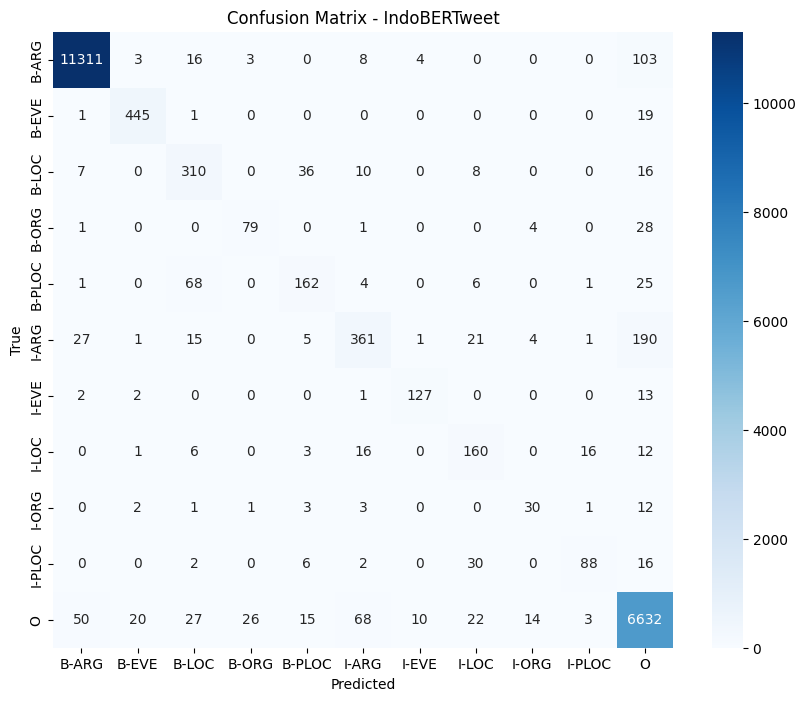


Examples for IndoBERTweet:
--------------------------------------------------
Sentence: [CLS] nagara institute sebut kebakaran di kejaksaan agung serangan ke negara [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Gold:     ['O', 'O', 'O', 'B-EVE', 'O', 'B-ARG', 'I-ARG', 'O', 'O', 'O', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG']
Pred:     ['B-ORG', 'I-ORG', 'O', 'B-EVE', 'O', 'B-ARG', 'O', 'O', 'O', 'O', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG', 'B-ARG

In [33]:
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score



# ----------------------------
# Run Evaluation
# ----------------------------
y_true_i, y_pred_i, flat_true_i, flat_pred_i = evaluate_model_indoberttweet(model_indoberttweet, test_loader_indoberttweet, le_indobert, device)
plot_confusion_matrix(flat_true_i, flat_pred_i, le_indobert.classes_, "IndoBERTweet")
show_examples_indobert(X_test_ids, y_true_i, y_pred_i,tokenizer=tokenizer, model_name="IndoBERTweet")
print("IndoBERTweet:       ", f1_score(y_true_i, y_pred_i, average="macro"))

In [34]:
# Entity-level (BIO spans) via seqeval
print("\n[Entity-level report — seqeval]")
print(seqm.classification_report(y_true_i, y_pred_i, digits=4))

# Token-level (per-label) via sklearn
print("\n[Token-level report — sklearn]")
print(skm.classification_report(flat_true_i, flat_pred_i, digits=4))


[Entity-level report — seqeval]
              precision    recall  f1-score   support

         ARG     0.9856    0.9838    0.9847     11449
         EVE     0.8863    0.9034    0.8948       466
         LOC     0.6468    0.7571    0.6976       387
         ORG     0.6306    0.6195    0.6250       113
        PLOC     0.6795    0.5955    0.6347       267

   micro avg     0.9610    0.9625    0.9617     12682
   macro avg     0.7658    0.7719    0.7674     12682
weighted avg     0.9620    0.9625    0.9620     12682


[Token-level report — sklearn]
              precision    recall  f1-score   support

       B-ARG     0.9922    0.9880    0.9901     11448
       B-EVE     0.9388    0.9549    0.9468       466
       B-LOC     0.6951    0.8010    0.7443       387
       B-ORG     0.7248    0.6991    0.7117       113
      B-PLOC     0.7043    0.6067    0.6519       267
       I-ARG     0.7616    0.5767    0.6564       626
       I-EVE     0.8944    0.8759    0.8850       145
       I-LOC 

# combined analysis


[Entity-level report — seqeval]
              precision    recall  f1-score   support

         ARG     0.5584    0.5253    0.5413       455
         EVE     0.9393    0.9413    0.9403       460
         LOC     0.6896    0.6626    0.6758       409
         ORG     0.6848    0.4773    0.5625       132
        PLOC     0.6205    0.5305    0.5720       262

   micro avg     0.7165    0.6665    0.6906      1718
   macro avg     0.6985    0.6274    0.6584      1718
weighted avg     0.7108    0.6665    0.6865      1718


[Token-level report — sklearn]
Token Accuracy: 0.8753138075313808
Macro F1: 0.7198587999657531
Macro Precision: 0.7515882800197272
Macro Recall: 0.6939592688658126
              precision    recall  f1-score   support

       B-ARG     0.7079    0.6659    0.6863       455
       B-EVE     0.9610    0.9630    0.9620       460
       B-LOC     0.7455    0.7164    0.7307       409
       B-ORG     0.7065    0.4924    0.5804       132
      B-PLOC     0.6429    0.5496    0.592

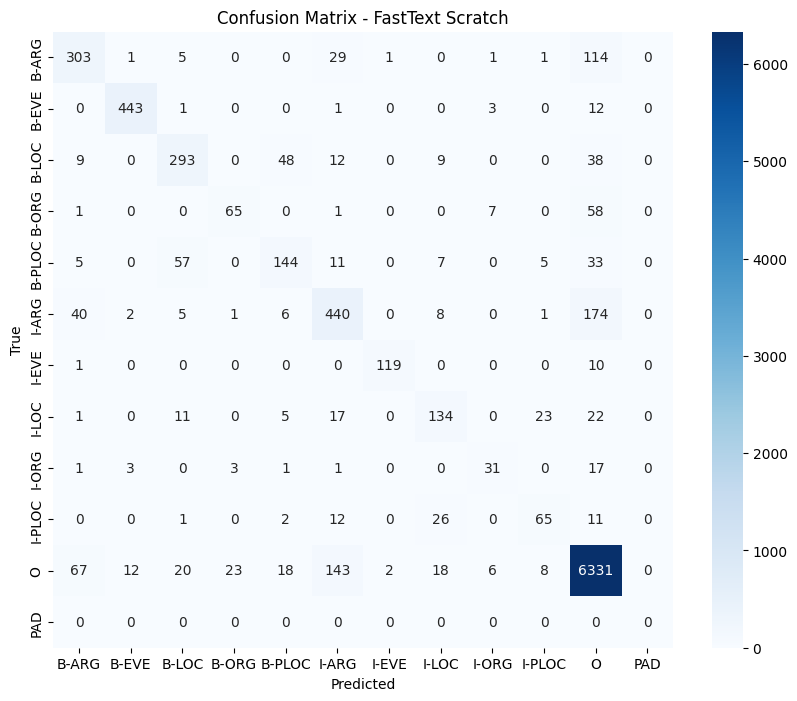

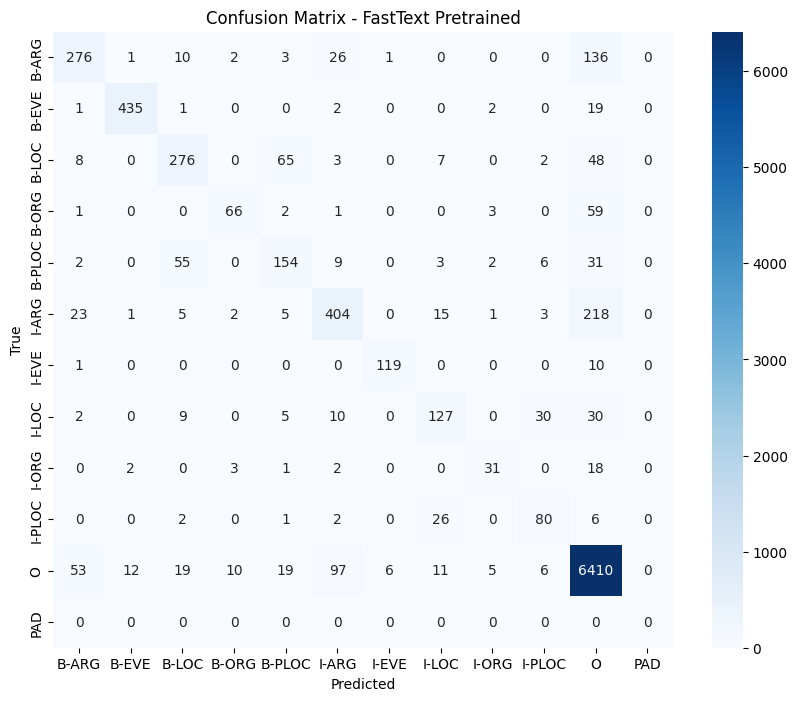

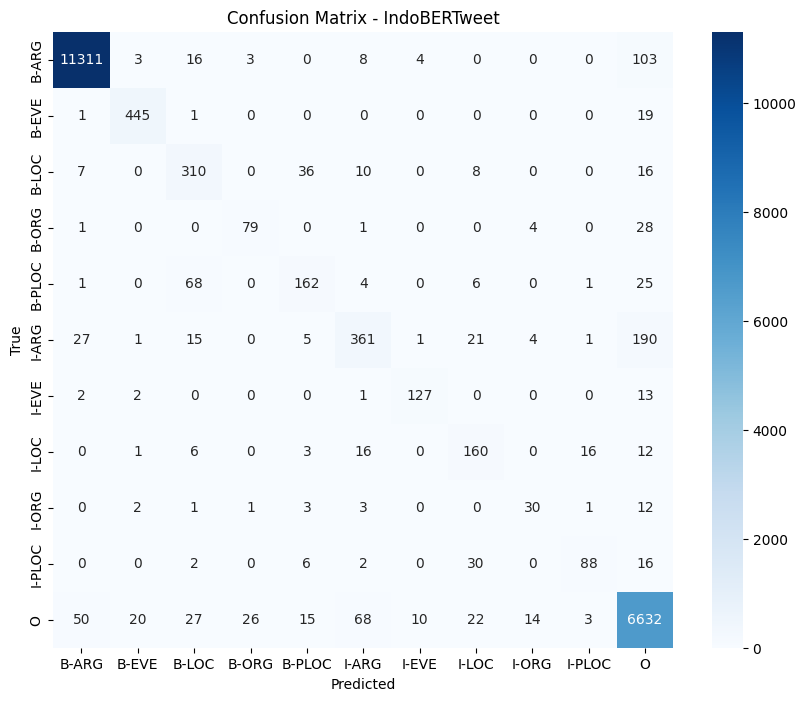


=== Example Predictions ===

[FastText Scratch]

[Sample Predictions — FastText-scratch BiLSTM-CRF]
Sentence:  13 janji akan mencari solusi banjir jakarta dan kemacetan jakarta ketika jadi presiden bahkan statemen di 2014 akan menggunakan cara lain namun faktanya kini banyak barisan pendukung yang menyalahkan anies
Gold:      ['O', 'O', 'O', 'O', 'O', 'O', 'B-EVE', 'O', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-PLOC', 'O', 'B-PLOC', 'O', 'O', 'O', 'B-EVE', 'O', 'B-ARG', 'I-ARG', 'I-ARG', 'O', 'B-ARG', 'O', 'O']
Pred:      ['O', 'O', 'O', 'O', 'O', 'O', 'B-EVE', 'O', 'B-LOC', 'B-PLOC', 'O', 'O', 'O', 'O', 'O', 'B-PLOC', 'O', 'B-PLOC', 'O', 'O', 'O', 'B-EVE', 'O', 'B-ARG', 'I-ARG', 'O', 'O', 'O', 'O', 'O']
--------------------------------------------------
Sentence:  anak buah bantu set up pusat pemindahan banjir di balairaya
Gold:      ['O', 'O', 'B-EVE', 'O', 'B-LOC', 'B-ARG', 'I-ARG', 'O', 'O', 'O']
Pred:      ['O', 'O', 'B-EVE', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O']
-----------

In [35]:


# ------------------------------
# 1. Run evaluations (each returns seq + flat labels)
# ------------------------------
y_true_s, y_pred_s, flat_true_s, flat_pred_s = evaluate_model_ftscratch(
    ft_model_scratch, test_loader_ftscratch, le_ft, device
)

y_true_p, y_pred_p, flat_true_p, flat_pred_p = evaluate_model_ftpretrain(
    model_ftpretrain, test_loader_ftpretrain, le_ftp, device
)

y_true_i, y_pred_i, flat_true_i, flat_pred_i = evaluate_model_indoberttweet(
    model_indoberttweet, test_loader_indoberttweet, le_indobert, device
)

# ------------------------------
# 2. Define a helper for token-level metrics
# ------------------------------
def compute_metrics(y_true, y_pred):
    return [
        skm.accuracy_score(y_true, y_pred),
        skm.precision_score(y_true, y_pred, average="macro", zero_division=0),
        skm.recall_score(y_true, y_pred, average="macro", zero_division=0),
        skm.f1_score(y_true, y_pred, average="macro", zero_division=0),
    ]

models = {
    "FastText Scratch": compute_metrics(flat_true_s, flat_pred_s),
    "FastText Pretrained": compute_metrics(flat_true_p, flat_pred_p),
    "IndoBERTweet": compute_metrics(flat_true_i, flat_pred_i),
}

metrics = ["Accuracy", "Precision", "Recall", "F1"]

# ------------------------------
# 3. Print metrics neatly
# ------------------------------
print("\n=== Token-level Metrics ===")
print(f"{'Metric':<10} | {'Scratch':>10} | {'Pretrained':>12} | {'IndoBERTweet':>14}")
print("-" * 55)
for i, metric in enumerate(metrics):
    print(f"{metric:<10} | {models['FastText Scratch'][i]:>10.4f} | "
          f"{models['FastText Pretrained'][i]:>12.4f} | "
          f"{models['IndoBERTweet'][i]:>14.4f}")

# ------------------------------
# 4. Plot confusion matrices
# ------------------------------
plot_confusion_matrix(flat_true_s, flat_pred_s, le_ft.classes_, "FastText Scratch")
plot_confusion_matrix(flat_true_p, flat_pred_p, le_ftp.classes_, "FastText Pretrained")
plot_confusion_matrix(flat_true_i, flat_pred_i, le_indobert.classes_, "IndoBERTweet")

# ------------------------------
# 5. Show example predictions
# ------------------------------
print("\n=== Example Predictions ===")

print("\n[FastText Scratch]")
show_examples_ftscratch(sentences_tokens, y_true_s, y_pred_s)

print("\n[FastText Pretrained]")
show_examples_ftpretrain(sentences_tokens, y_true_p, y_pred_p, model_name="FastText Pretrained")

print("\n[IndoBERTweet]")
show_examples_indobert(X_test_ids, y_true_i, y_pred_i, tokenizer=tokenizer, model_name="IndoBERTweet")
